Packages that need to be installed and executed beforehand.

In [1]:
import os, glob, random, itertools, calendar, datetime
from tqdm import tqdm
import missingno as mn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pymannkendall as mk
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates 
from calendar import month_name
month_lookup = list(month_name)
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# **Function designed to filter and select data** #

In [2]:
def New_method_filter(df, percent = 90, start = '2001-01-01', end = '2020-12-31' ):   
    
    """
    Implement an updated methodology for selecting data for future trend analysis, as described in the IGRAC report.

    Parameters:
    - df (DataFrame): DataFrame with time series.
    - percent (int): Selected threshold to filter data (default: 90).
    - start (str, '%Y-%m-%d'): Initial date for analysis (default: '2001-01-01').
    - end (str, '%Y-%m-%d'): Final date for analysis (default: '2020-12-31').

    Output:
    - Accepted (DataFrame): Data above the chosen threshold between the selected dates.
    - Rejected (DataFrame): Data below the chosen threshold between the selected dates.
    """

    
    start = datetime.strptime(start , '%Y-%m-%d')
    end = datetime.strptime(end , '%Y-%m-%d')
    
    df = df[(df.index >= start) & (df.index <= end)]
    
    Total_wells = len(list(df))
    
    Total_years_period = (len(df)/12)
    
    Total_years = (len(df)/12) * (percent*0.01)
    
    

    print(f"The chosen period covers {Total_years_period} years between {start:%Y-%m-%d} and {end:%Y-%m-%d}")
    print(f"With the {percent}% condition this period will accept {np.ceil(Total_years)}({round(Total_years,1)}) of {Total_years_period}")
    
    
    Final_df = []
    Rest_df = []

    for m, n in tqdm(enumerate(list(df))):


        Time_serie = df.iloc[:,m].reset_index()
        Time_serie_MC = Time_serie.groupby([Time_serie['Fecha'].dt.month_name()], sort=False).count()
        Meses_mas_datos = Time_serie_MC.drop(columns = 'Fecha').sort_values(by = n, ascending=False).index


        Month_number = []
        for h in Meses_mas_datos:
            Month_number.append(list(calendar.month_name).index(h))


        Month_complete = []
        Rest = [df.iloc[:,m]]

        for i,j in enumerate(Month_number) :

            #print(i,j)
            comp_dates = pd.DataFrame(pd.date_range(start=start+ pd.DateOffset(months=-1),\
                                                    end= end+ pd.DateOffset(months=+1), freq='M'), \
                                      columns=['Fecha'])
            Test1 = comp_dates.merge(Rest[i].reset_index(), how='left', on='Fecha')
            Rest[i] = pd.Series(Test1.iloc[:,1].values, index= Test1.iloc[:,0].values,\
                                name = Test1.iloc[:,1].name)
            Rest[i].index.name = 'Fecha'


            Remaining_1 = Rest[i][Rest[i].index.month != j]

            Sel_period = Rest[i][(Rest[i].index >= start) & (Rest[i].index <= end)]
            Month_sel = Sel_period[Sel_period.index.month == j ]


            Month_sel_nan = Month_sel[Month_sel.isnull()]
            #print(Month_sel_nan)

            #Estos son los seleccionados que no son NaN

            Month_sel_nonan = Month_sel.dropna()

            if len(Month_sel_nonan) == Total_years_period:

                Month_complete.append(Month_sel_nonan)
                Rest.append(Remaining_1)

            elif len(Month_sel_nonan) < Total_years_period:
                #print(i,j)



                Valores_reemplazo = [Month_sel_nonan]

                for k,h in enumerate(Month_sel_nan):


                    if  ~np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0)]) & \
                        ~np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0)]) == True:

                        Month_sel_nan[k] = np.mean([Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0)]\
                                                    , Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0)]])
        

                    elif  ~np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0)]) == True:


                        Value = Remaining_1.loc[[Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0)]]

                        Valores_reemplazo.append(Value)


                        Remaining_1 = Remaining_1.drop(Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0))


                    elif  ~np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0)]) == True:


                        Value = Remaining_1.loc[[Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0)]]


                        Valores_reemplazo.append(Value)


                        Remaining_1 = Remaining_1.drop(Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0))


                    elif np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=-1)+ pd.offsets.MonthEnd(n=0)]) & \
                        np.isnan(Remaining_1[Month_sel_nan.index[k] + pd.DateOffset(months=+1)+ pd.offsets.MonthEnd(n=0)]) == True:

                        continue


                Paso1 = pd.concat(Valores_reemplazo).sort_index()



                if len(pd.concat([Paso1,Month_sel_nan.dropna()]).sort_index()) >= Total_years:



                    Month_complete.append(pd.concat([Paso1,Month_sel_nan.dropna()]).sort_index())
                    Rest.append(Remaining_1)

                else:

                    Rest.append(Rest[i])


        comp_dates1 = pd.DataFrame(pd.date_range(start=start, end=end, freq='M'), columns=['Fecha'])
        
        if len(Month_complete)>0 :

            Time_serie_NONAN = pd.concat(Month_complete).sort_index().reset_index()
            Final_Time_serie = comp_dates1.merge(Time_serie_NONAN, how='left', on='Fecha').set_index('Fecha')
            Rest_Time_serie = comp_dates1.merge(Rest[-1], how='left', on='Fecha').set_index('Fecha')
            Final_df.append(Final_Time_serie)
            Rest_df.append(Rest_Time_serie)
        else:

            Rest_Time_serie = comp_dates1.merge(Rest[-1], how='left', on='Fecha').set_index('Fecha')            
            Rest_df.append(Rest_Time_serie)           

    if len(Final_df) >0:
        
        print(f"{len(Final_df)} well(s) accepted out of {Total_wells}")
        Final_accepted = pd.concat(Final_df, axis = 1)
        Not_accepted = pd.concat(Rest_df, axis = 1)
    else: 
        
        print(f"0 wells accepted out of {Total_wells}")
        Final_accepted = pd.Dataframe()
        Not_accepted = pd.concat(Rest_df, axis = 1)
        

    
    return Final_accepted, Not_accepted

## **Function designed to effectively visualize time series data** ##

In [3]:
def Test_plot(df, sharex = True, sharey = False, savefig = False):
    
    """
    Generate a test plot for exploratory analysis (It is recommended not to plot more than 100 samples).

    Parameters:
    - df (DataFrame): DataFrame containing data for plotting 
                     (It is recommended not to plot more than 100 samples.)
    - sharex (bool): If True, share the x-axis among subplots (default: True).
    - sharey (bool): If True, share the y-axis among subplots (default: False).
    - savefig (bool): If True, save the generated plot as an image file (default: False).

    Output:
    - Matplotlib Figure: Test plot for exploratory analysis.
    """

    if len(list(df)) > 100:
        print('Make a sample!')
        #break
        
    else:
    
        fig, ax = plt.subplots(len(list(df)), 1, figsize = (12, len(list(df))*2), sharex = sharex, sharey = sharey)#, sharey = True)
        for i, j in tqdm(enumerate(list(df)[:len(list(df))])):
            ax[i].set_title(j, fontsize = 6)
            ax[i].plot(df.index, df[j], markersize=2, marker = "o",  color = 'darkblue', linestyle ='')
            ax[i].set_xlim(df.index[0]+ pd.DateOffset(months=-2), df.index[-1]+ pd.DateOffset(months=+2))
            ax[i].invert_yaxis()
            ax[i].grid()

            loc = mdates.YearLocator(1)
            ax[i].xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter('%Y')
            ax[i].xaxis.set_major_formatter(fmt)

            ax[i].figure.autofmt_xdate(rotation=45, ha='center')
            #plt.tight_layout()

            #ax.set_xticks(fms, labels, rotation=45, ha='right')
            plt.show

        if savefig == True:

            name = str(input('Nombre del archivo PNG: '))
            plt.savefig(f'{name}.png')#, bbox_inches='tight')

        
    return

## **Function disegned to show te distrution of data in time series plot** ##

In [4]:
def Data_distribution(df, savefig = False):
    
    """
    Generate a plot to visualize the distribution of data.

    Parameters:
    - df (DataFrame): DataFrame containing the data for distribution visualization.
    - savefig (bool): If True, save the generated plot as an image file (default: False).

    Output:
    - Matplotlib Figure: Plot visualizing the distribution of data.
    """

    mn.matrix(df, freq = 'Y')

    if savefig == True:

        name = str(input('Nombre del archivo PNG: '))
        plt.savefig(f'{name}.png', bbox_inches='tight')    
    
    plt.show()
    return 

## **Function designed for comparing data acceptance and data rejection** ##

In [5]:
def Test_plot_2(df1, df2, savefig = False):
    
    """
    Generate a plot to visualize and compare data acceptance and data rejection from the New_method_filter function.

    Parameters:
    - df1 (DataFrame): Accepted data DataFrame from the New_method_filter function.
    - df2 (DataFrame): Rejected data DataFrame from the New_method_filter function.
    - savefig (bool): If True, save the generated plot as an image file (default: False).

    Output:
    - Matplotlib Figure: Plot visualizing and comparing data acceptance and rejection.
    """
    
    if len(list(df1)) > 100:
        print('Make a sample!')
        #break
    
    else:


        num_wells = len(list(df1))


        fig, ax = plt.subplots(num_wells, 1, figsize = (12,num_wells*2), sharex = True)#, sharey = True)

        for i, j in tqdm(enumerate(list(df1))):

            ax[i].set_title(j, fontsize = 6)
            ax[i].plot(df1.index, df1[j], markersize=2, marker = "o",  color = 'darkblue', linestyle ='')
            ax[i].plot(df2.index, df2[j], markersize=2, marker = "o", color = 'lightblue', linestyle ='')

            ax[i].set_xlim(df1.index[0], df1.index[-1])
            #ax[i] = plt.gca()
            ax[i].invert_yaxis()
            ax[i].grid()

            loc = mdates.YearLocator(1)
            ax[i].xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter('%Y')
            ax[i].xaxis.set_major_formatter(fmt)

            ax[i].figure.autofmt_xdate(rotation=45, ha='center')
            #ax[i] = plt.gca()

            #plt.tight_layout()

            plt.show
            
        if savefig == True:

            name = str(input('Nombre del archivo PNG: '))
            plt.savefig(f'{name}.png', bbox_inches='tight')

        
    return 

## **Function developed for visualizing autocorrelation analysis in time series** ##

In [6]:
def Autocorrelation(df, missing = 'drop'):
    
    """
    Plot the autocorrelation function using Statsmodels and display the occurring lags.

    Parameters:
    - df (DataFrame): DataFrame containing the time series data.
    - missing (str): String in ['none', 'raise', 'conservative', 'drop'] specifying how NaNs are treated (default: 'drop').

    Output:
    - Matplotlib Figure: Autocorrelation plot.
    """
    
    wells_num = len(list(df))


    fig, ax = plt.subplots(wells_num, 1, figsize = (10,wells_num*2), sharey = True, constrained_layout=True)
    
    fig.subplots_adjust(top=2,bottom=1)

    for i, j in tqdm(enumerate(list(df)[:wells_num])):
        
        acf, ci = sm.tsa.acf(df.iloc[:,i], nlags= len(df.iloc[:,i]), alpha=0.05 , missing = missing)

        nlags = []


        for k in np.arange(1,len(acf)):

            if np.abs(acf[k]) - np.abs((ci[k]-acf[k])[0]) > 0:

                nlags.append(k)
        
        label_1 = 'Nº Lags = ' + str(nlags)
        
        if missing == 'drop':
        
        
            sm.graphics.tsa.plot_acf(df.iloc[:,i], lags=(len(df.iloc[:,i].dropna()))-1\
                                 , ax=ax[i], missing = missing, label = label_1)
        
        else:
            
            sm.graphics.tsa.plot_acf(df.iloc[:,i], lags=(len(df.iloc[:,i]))-1\
                                 , ax=ax[i], missing = missing, label = label_1)
        
        handles, labels= ax[i].get_legend_handles_labels()
        
        handles=handles[1:2]
        labels =labels[1:2]

        ax[i].set_title(j, fontsize = 8)
        
        ax[i].legend(handles=handles, labels=labels, bbox_to_anchor=(1, 1), loc = 'best')
        
        #labels=labels
        
        ax[i].xaxis.set_tick_params(labelsize=6)
        ax[i].yaxis.set_tick_params(labelsize=6)
        ax[i].grid()
        
        plt.tight_layout

        plt.show  
    
    return

## **Function created to perform various Mann-Kendall tests** ##

In [7]:
def MK_tests(df, num1 = 1, num2 = 2, alpha = 0.1):
    
    """
    Perform various Mann-Kendall tests from pykmannkendall package to compare results.

    Parameters:
    - df (DataFrame): DataFrame with time series.
    - num1 (int): Number from 1 to 5, representing the Mann-Kendall test to perform:
        1: 'mk.original_test',
        2: 'mk.hamed_rao_modification_test',
        3: 'mk.yue_wang_modification_test',
        4: 'mk.trend_free_pre_whitening_modification_test',
        5: 'mk.pre_whitening_modification_test'.
    - num2 (int): Number from 1 to 6, representing the Mann-Kendall test to perform. It allows performing Seasonal Mann-Kendall Test:
        6: 'mk.seasonal_test'.
    - alpha (float): Significance level (0.1 is the default).

    Output:
    DataFrame: Results of the Mann-Kendall tests.
    """
    

    Dict = {1 : 'mk.original_test',
    2 : 'mk.hamed_rao_modification_test',
    3: 'mk.yue_wang_modification_test',
    4: 'mk.trend_free_pre_whitening_modification_test',
    5: 'mk.pre_whitening_modification_test',
    6: 'mk.seasonal_test'}    
    
    print(f'Mann Kendall Test to execute: {Dict[num1]} y {Dict[num2]}')    

    d = []
    Auto = []
    
    for i, j in enumerate(list(df)[:len(list(df))]):
        

        if (num1 == 1):

            result1 =  mk.original_test(df.iloc[:,i], alpha=alpha)

        if (num1 == 2):

            result1 = mk.hamed_rao_modification_test(df.iloc[:,i], alpha=alpha)

        if (num1 == 3):

            result1 = mk.yue_wang_modification_test(df.iloc[:,i], alpha=alpha)        

        if (num1 == 4):

            result1 = mk.trend_free_pre_whitening_modification_test(df.iloc[:,i], alpha=alpha)  

        if (num1 == 5):

            result1 = mk.pre_whitening_modification_test(df.iloc[:,i], alpha=alpha) 

        if (num1 == 6):

            result1 = mk.seasonal_test(df.iloc[:,i], alpha=alpha, period = 12)  

        if (num2 == 1):

            result2 =  mk.original_test(df.iloc[:,i], alpha=alpha)

        if (num2 == 2):

            result2 = mk.hamed_rao_modification_test(df.iloc[:,i], alpha=alpha)

        if (num2 == 3):

            result2 = mk.yue_wang_modification_test(df.iloc[:,i], alpha=alpha)        

        if (num2 == 4):

            result2 = mk.trend_free_pre_whitening_modification_test(df.iloc[:,i], alpha=alpha)  

        if (num2 == 5):

            result2 = mk.pre_whitening_modification_test(df.iloc[:,i], alpha=alpha) 

        if (num2 == 6):

            result2 = mk.seasonal_test(df.iloc[:,i], alpha=alpha, period = 12)

        d.append(
            {
                'Well': j,
                'Trends_MK1': result1.trend,
                'Trends_MK2': result2.trend,
                'h_MK1': result1.h,
                'h_MK2': result2.h,
                'p_MK1': result1.p,
                'p_MK2': result2.p,
                #'z': result1.z,
                #'Tau': results.Tau,
                #'s': result1.s,
                #'var_s': results.var_s,
                'slope_MK1': result1.slope,
                'slope_MK2': result2.slope,
                'intercept_MK1': result1.intercept,
                'intercept_MK2': result2.intercept,
            }
        )

        acf, ci = sm.tsa.acf(df.iloc[:,i], nlags= len(df.iloc[:,i]), alpha=0.05 , missing = "drop")

        nlags = []


        for k in np.arange(1,len(acf)):

            if np.abs(acf[k]) - np.abs((ci[k]-acf[k])[0]) > 0:

                nlags.append(k)
                
        Auto.append(nlags)
    
    N_lags = []
    for j in range(len(Auto)):
        N_lags.append(len(Auto[j]))
        


    Mk_results = pd.DataFrame(d)
    Autocorrelation = pd.Series(Auto, name = 'Autocorrelation')
    Num_lags = pd.Series(N_lags, name = 'Nº Lags')
    
    Mk_results_autocorrelation = pd.concat([Mk_results, Autocorrelation, Num_lags], axis = 1)
    
    Mk_results_autocorrelation['Trends_MK1'].replace(['decreasing','increasing'],['increasing','decreasing'], inplace = True)
    Mk_results_autocorrelation['Trends_MK2'].replace(['decreasing','increasing'],['increasing','decreasing'], inplace = True)
        
    return Mk_results_autocorrelation

## **Function created to visualize various Mann-Kendall tests** ##

In [8]:
def MK_plot(df, num1 = 1, num2 = 2, alpha = 0.1, savefig = False):

    """
    Perform various Mann-Kendall tests visualizations to compare results.

    Parameters:
    - df (DataFrame): DataFrame with time series.
    - num1 (int): Number from 1 to 5, representing the Mann-Kendall test to perform:
        1: 'mk.original_test',
        2: 'mk.hamed_rao_modification_test',
        3: 'mk.yue_wang_modification_test',
        4: 'mk.trend_free_pre_whitening_modification_test',
        5: 'mk.pre_whitening_modification_test'.
    - num2 (int): Number from 1 to 6, representing the Mann-Kendall test to perform. It allows performing Seasonal Mann-Kendall Test:
        6: 'mk.seasonal_test'.
    - alpha (float): Significance level (0.05 is the default).
    - savefig (bool): If True, the figure is saved as a .png file.

    Output:
    - Visualization: Results of the Mann-Kendall tests.
    - Printed figure (optional).
    
    """

    df_year = df.resample('1Y').mean()
    num_años = len(df_year)
    num_meses = len(df)
    num_wells = len(list(df))
    x = np.arange(0,num_meses)
    x_seasonal = np.arange(0,num_años)
    
    Mk_results = MK_tests(df, num1 = num1, num2 = num2, alpha = alpha)
    

    fig, ax = plt.subplots(num_wells, 1, figsize = (12,num_wells*2.5), sharex = True)#, sharey = True)

    for i, j in tqdm(enumerate(list(df)[:len(list(df))])):
        
        if (num1 !=6 )&(num2 !=6):

            y = Mk_results.slope_MK1[i]*x + Mk_results.intercept_MK1[i]

            label_1 = 'Slope = ' + str(round(Mk_results.slope_MK1[i],4)*-1)+\
                    "\nTrend_Mk1 = "+ str(Mk_results.Trends_MK1[i])+\
                    "\nTrend_Mk2 = "+ str(Mk_results.Trends_MK2[i])+\
                    "\np_Mk1 = " + str(round(Mk_results.p_MK1[i],4))+\
                    "\np_Mk2 = " + str(round(Mk_results.p_MK2[i],4))     

            ax[i].set_title(j, fontsize = 6)
            #ax[i].set_ylim([0,89])

            ax[i].plot(df.index, df[j], markersize=2, marker = "o", color = "darkblue", linestyle ='')

            ax[i].plot(df.index, y, color='red', linewidth = 0.5, label = label_1)

            ax[i].set_xlim(df.index[0]-pd.DateOffset(months=2), df.index[-1]+ pd.DateOffset(months=2))
            #ax[i] = plt.gca()
            ax[i].legend(bbox_to_anchor=(1, 1), loc = 2)
            #ax[i].legend()
            ax[i].invert_yaxis()
            ax[i].grid()

            loc = mdates.YearLocator(1)
            ax[i].xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter('%Y')
            ax[i].xaxis.set_major_formatter(fmt)

            ax[i].figure.autofmt_xdate(rotation=45, ha='center')
            #ax[i] = plt.gca()

            #plt.tight_layout()
            plt.show
            

        
        else:

            y = Mk_results.slope_MK1[i]*x + Mk_results.intercept_MK1[i]
            y2 = Mk_results.slope_MK2[i]*x_seasonal + Mk_results.intercept_MK2[i]

            label_2 = 'Slope_MK1 = ' + str(round(Mk_results.slope_MK1[i],4)*-1)+\
                '\nSlope_MK2 = ' + str(round(Mk_results.slope_MK2[i],4)*-1)+\
                "\nTrend_Mk1 = "+ str(Mk_results.Trends_MK1[i])+\
                "\nTrend_Mk2 = "+ str(Mk_results.Trends_MK2[i])+\
                "\np_Mk1 = " + str(round(Mk_results.p_MK1[i],4))+\
                "\np_Mk2 = " + str(round(Mk_results.p_MK2[i],4))


            ax[i].set_title(j, fontsize = 6)

            ax[i].plot(df.index, df[j], markersize=2, marker = "o", color = "darkblue", linestyle ='')



            ax[i].plot(df.index, y, color='red', linewidth = 0.5, label = label_2)

            ax[i].plot(df_year.index - pd.DateOffset(months=11), y2, color='green', linewidth = 0.5)



            ax[i].set_xlim(df.index[0]- pd.DateOffset(months=2), df.index[-1]+ pd.DateOffset(months=2))
            ax[i].legend(bbox_to_anchor=(1, 1), loc = 2)
            ax[i].invert_yaxis()
            ax[i].grid()

            loc = mdates.YearLocator(1)
            ax[i].xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter('%Y')
            ax[i].xaxis.set_major_formatter(fmt)

            ax[i].figure.autofmt_xdate(rotation=45, ha='center')
            #ax[i] = plt.gca()

            #plt.tight_layout()
            plt.show
            


    if savefig == True:

        name = str(input('Nombre del archivo PNG: '))
        plt.savefig(f'{name}.png', bbox_inches='tight')

    return

# **Exploratory data analysis** #

In [9]:
#path = '/Users/sebastianpachecomercado/Desktop/Otros Trabajos/UNAP/Pasantía/Trabajo/Ogallala/New Ogallala/'
#os.chdir(path)

For the analysis data must be tabulated and monthly resampled as shows next

In [10]:
Ogallala_2001_2020 = pd.read_csv('Ogallala_2001_2020.csv', parse_dates = True, index_col = 'Fecha')

In [11]:
Ogallala_2001_2020

,TWDB536402,TWDB2357807,CODWR152905,TWDB636812,TWDB346302,CODWR152879,KSGS374530100272701,KSGS380338098550101,TWDB523601,TWDB1146701,...,TWDB352702,TWDB1048302,TWDB639301,TWDB1022801,TWDB2305803,TWDB2302205,TWDB2328901,TWDB2408501,TWDB2325401,TWDB233501
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-31,2.56,NaN,NaN,NaN,NaN,NaN,NaN,9.58,NaN,NaN,...,NaN,NaN,NaN,NaN,87.27,NaN,29.21,51.75,42.38,NaN
2001-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.71,...,NaN,73.88,NaN,59.8,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,NaN,NaN,NaN,NaN,98.05,NaN,NaN,NaN,NaN,NaN,...,78.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.38,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Basic Data Cleaning

In [12]:
Ogallala_2001_2020.describe().T

,count,mean,std,min,25%,50%,75%,max
TWDB536402,19.0,2.706842,0.139246,2.41,2.6350,2.68,2.8150,2.96
TWDB2357807,9.0,9.460000,0.840104,8.27,9.0100,9.13,10.1200,10.87
CODWR152905,3.0,20.730000,0.000000,20.73,20.7300,20.73,20.7300,20.73
TWDB636812,13.0,165.825385,4.028961,156.36,163.6800,165.81,167.6400,171.95
TWDB346302,14.0,106.809286,5.957579,98.05,100.9475,107.79,109.3825,117.69
...,...,...,...,...,...,...,...,...
TWDB2302205,9.0,72.020000,0.389936,71.23,71.9800,72.09,72.2300,72.46
TWDB2328901,18.0,30.642778,1.006238,29.03,29.9125,30.92,31.4175,31.96
TWDB2408501,20.0,54.934000,2.119385,51.67,52.9900,54.97,56.7750,58.38
TWDB2325401,20.0,41.099500,0.687294,39.87,40.6475,41.05,41.5475,42.38


Removing time series with no data

In [13]:
a = Ogallala_2001_2020.describe().T 
b = a[a['count'] != 0]
Ogallala_2001_2020 = Ogallala_2001_2020[list(b.T)]

In [14]:
Ogallala_2001_2020

,TWDB536402,TWDB2357807,CODWR152905,TWDB636812,TWDB346302,CODWR152879,KSGS374530100272701,KSGS380338098550101,TWDB523601,TWDB1146701,...,TWDB352702,TWDB1048302,TWDB639301,TWDB1022801,TWDB2305803,TWDB2302205,TWDB2328901,TWDB2408501,TWDB2325401,TWDB233501
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-31,2.56,NaN,NaN,NaN,NaN,NaN,NaN,9.58,NaN,NaN,...,NaN,NaN,NaN,NaN,87.27,NaN,29.21,51.75,42.38,NaN
2001-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.71,...,NaN,73.88,NaN,59.8,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,NaN,NaN,NaN,NaN,98.05,NaN,NaN,NaN,NaN,NaN,...,78.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.38,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Remarks**

Further exploration could be done as analysing 0, 9999, negative or outlier values.

# **Implementation of the updated methodology for data selection** #

As there are 4100 Ogallala wells, the code may take some time to analyze such a large dataset. For the demonstration, I will work with a sample of 50 wells.

In [15]:
sample = random.sample(list(Ogallala_2001_2020), 50)

In [16]:
Ogallala_sample = Ogallala_2001_2020[sample]

50it [00:10,  4.86it/s]


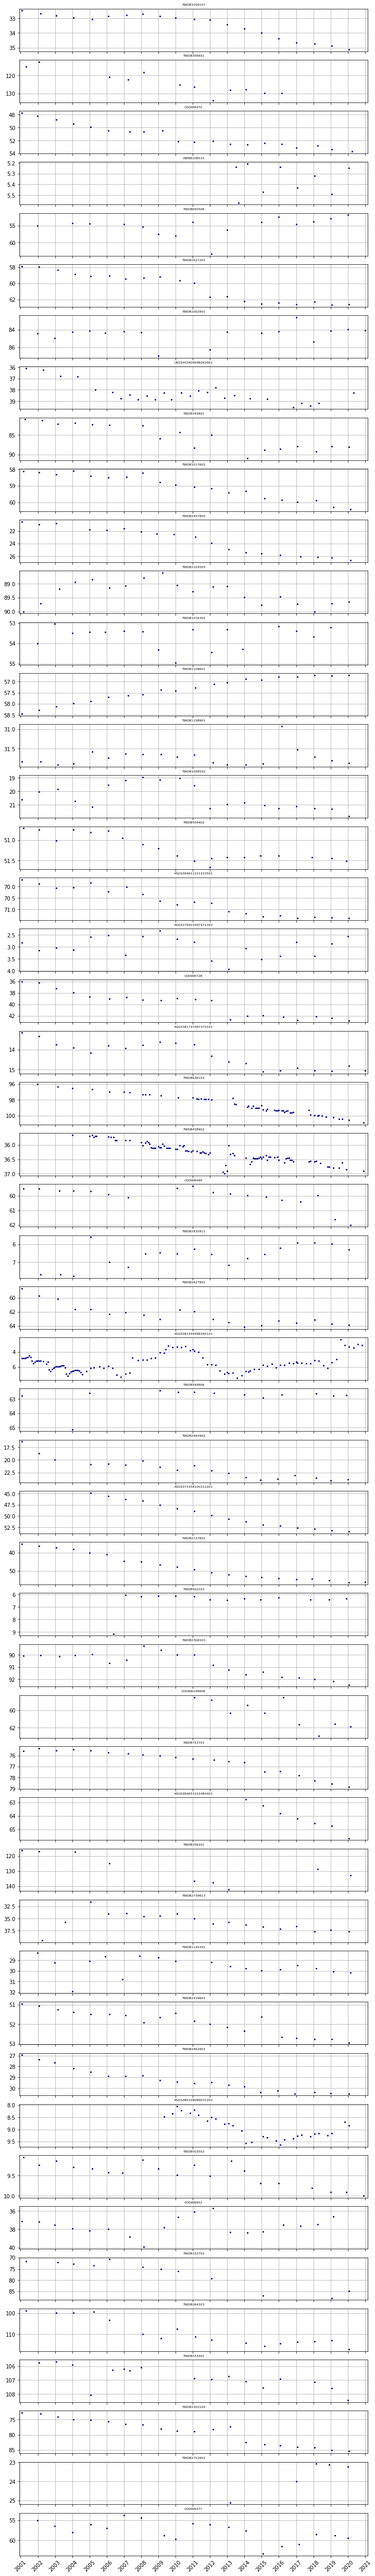

In [17]:
Test_plot(Ogallala_sample)

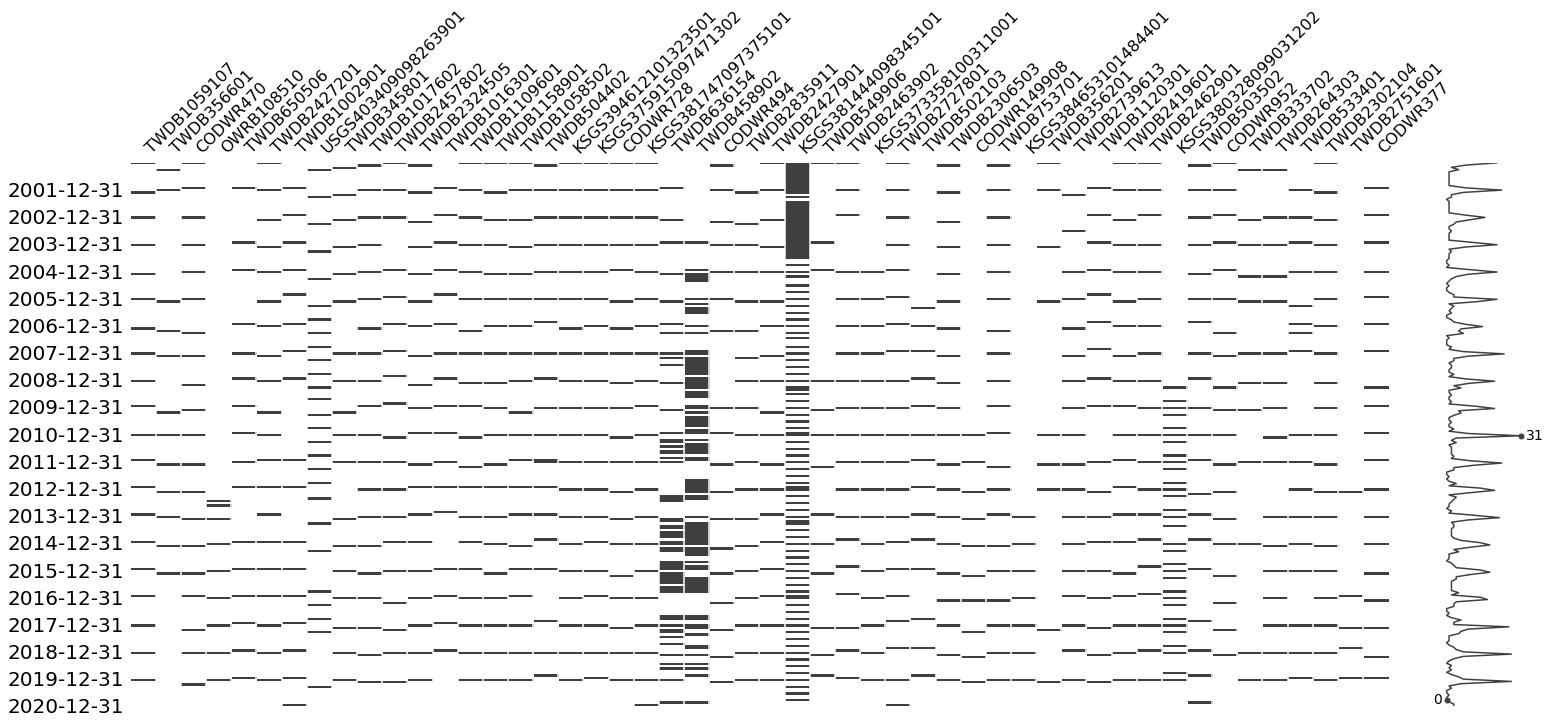

In [18]:
Data_distribution(Ogallala_sample)

First, I'll try with a threshold of 90%, on function by default.

In [19]:
Accepted_90, Rejected_90 = New_method_filter(Ogallala_sample)

The chosen period covers 20.0 years between 2001-01-01 and 2020-12-31
With the 90% condition this period will accept 18.0(18.0) of 20.0


50it [00:10,  4.76it/s]

23 well(s) accepted out of 50


To implement different thresholds, simply modify the variable named 'percent'.

In [20]:
Accepted_80, Rejected_80 = New_method_filter(Ogallala_sample, percent = 80)

The chosen period covers 20.0 years between 2001-01-01 and 2020-12-31
With the 80% condition this period will accept 16.0(16.0) of 20.0


50it [00:09,  5.10it/s]

36 well(s) accepted out of 50


In [21]:
Accepted_90.head()

,TWDB1059107,TWDB2427201,USGS403409098263901,TWDB345801,TWDB1017602,TWDB2324505,TWDB1109601,TWDB1158901,TWDB1058502,TWDB504402,...,KSGS381747097375101,TWDB2835911,TWDB2427901,KSGS381444098345101,TWDB2727801,TWDB2306503,TWDB753701,TWDB2419601,TWDB2462901,TWDB2302104
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-31,32.48,57.86,NaN,NaN,NaN,NaN,58.45,31.82,20.62,NaN,...,13.15,NaN,58.68,4.86,35.2,NaN,NaN,50.95,NaN,72.72
2001-02-28,NaN,NaN,NaN,NaN,58.13,90.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,90.06,75.6,NaN,NaN,NaN
2001-03-31,NaN,NaN,NaN,80.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,NaN,NaN,36.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.78,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
Accepted_80.head()

,TWDB1059107,CODWR470,TWDB650506,TWDB2427201,TWDB1002901,USGS403409098263901,TWDB345801,TWDB1017602,TWDB2324505,TWDB1016301,...,TWDB2727801,TWDB2306503,TWDB753701,TWDB2739613,TWDB2419601,TWDB2462901,TWDB503502,TWDB264303,TWDB2302104,CODWR377
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-31,32.48,47.73,NaN,57.86,NaN,NaN,NaN,NaN,NaN,NaN,...,35.2,NaN,NaN,NaN,50.95,26.94,NaN,NaN,72.72,NaN
2001-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.13,90.0,NaN,...,NaN,90.06,75.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,NaN,NaN,NaN,NaN,NaN,NaN,80.98,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,NaN,NaN,NaN,NaN,NaN,36.09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Visualization of the accepted and rejected measurement with different thresholds

23it [00:04,  5.58it/s]


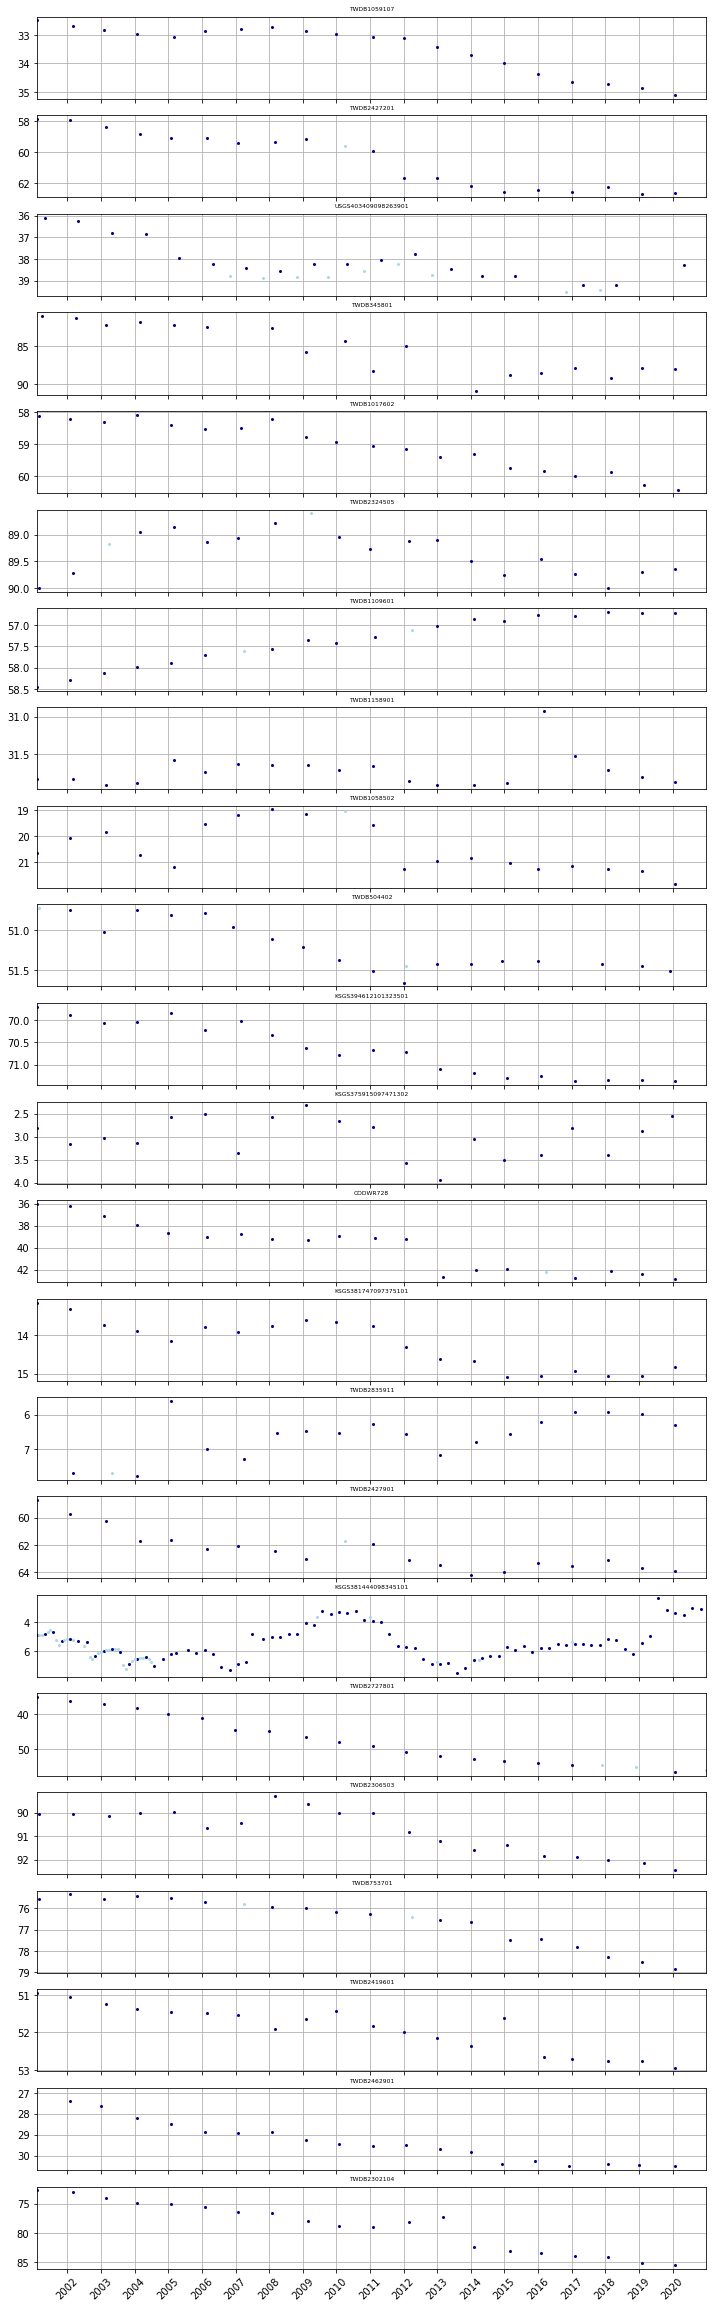

In [23]:
Test_plot_2(Accepted_90, Rejected_90)

36it [00:07,  5.08it/s]


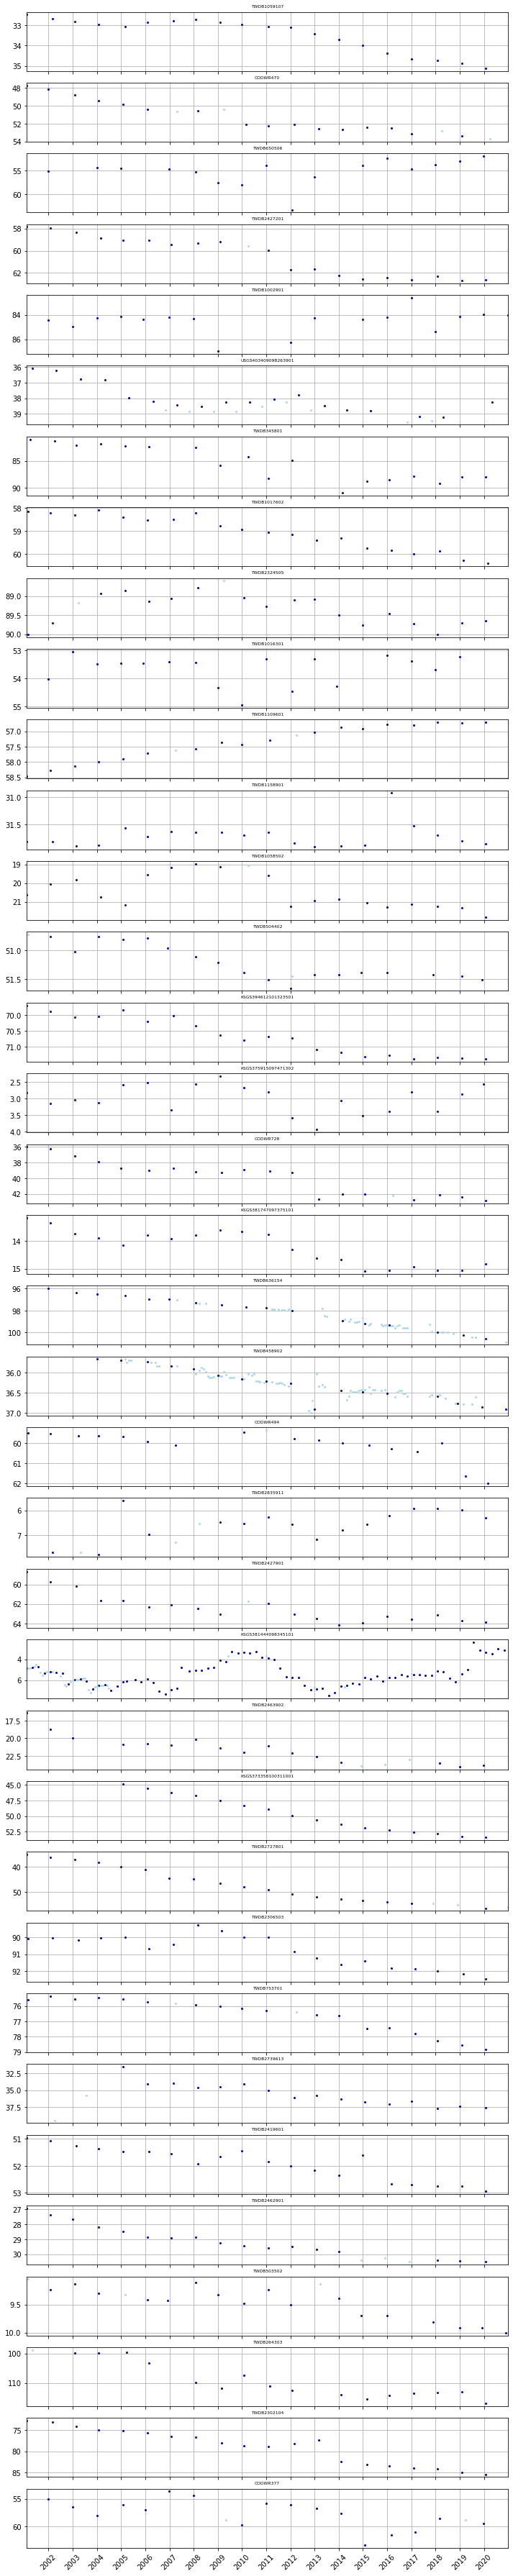

In [24]:
Test_plot_2(Accepted_80, Rejected_80)

Autocorrelation analysis applied to the selected data in both cases. On the legends it will identify the lags

23it [00:00, 59.88it/s]


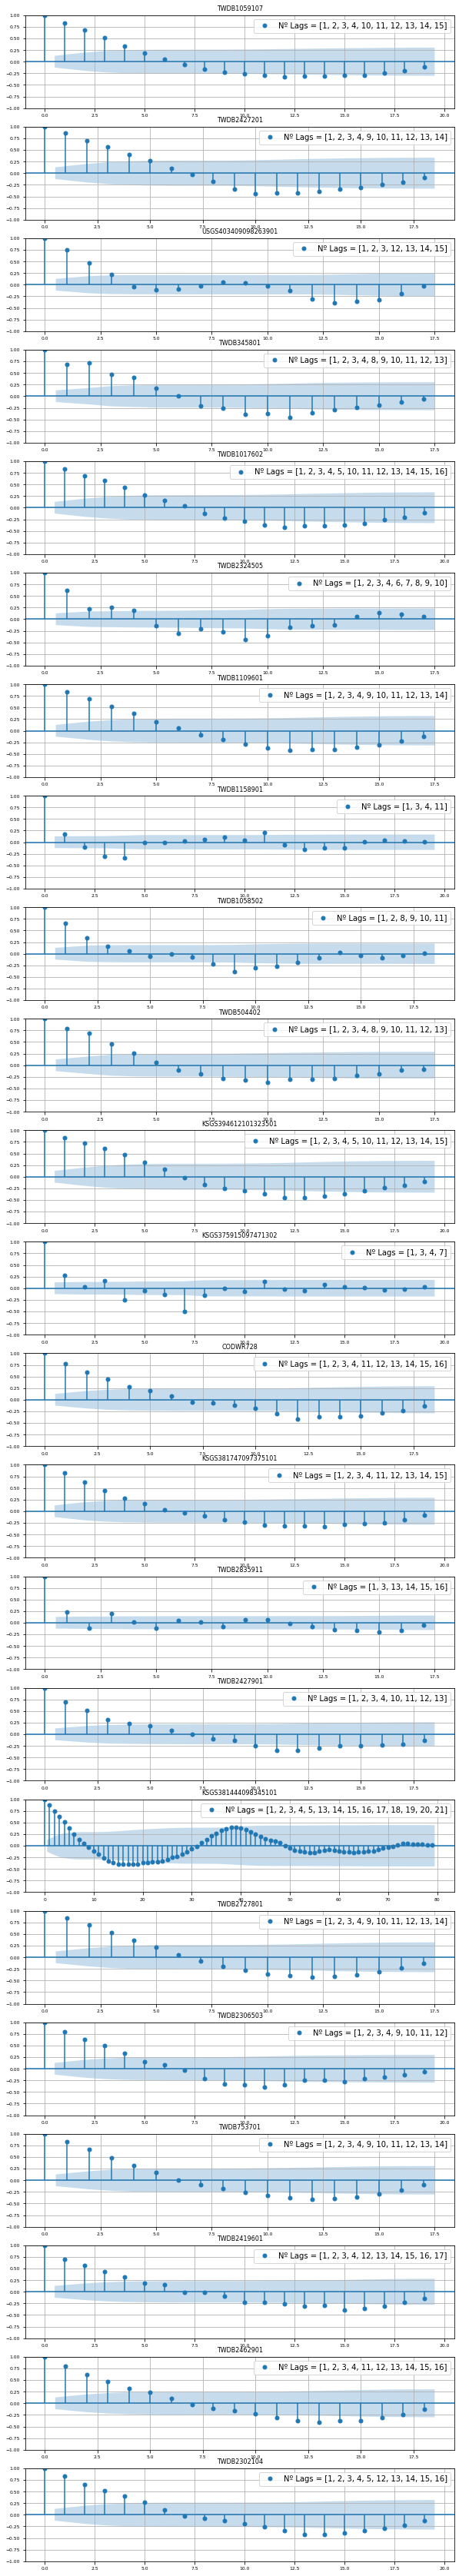

In [25]:
Autocorrelation(Accepted_90)

36it [00:00, 115.99it/s]


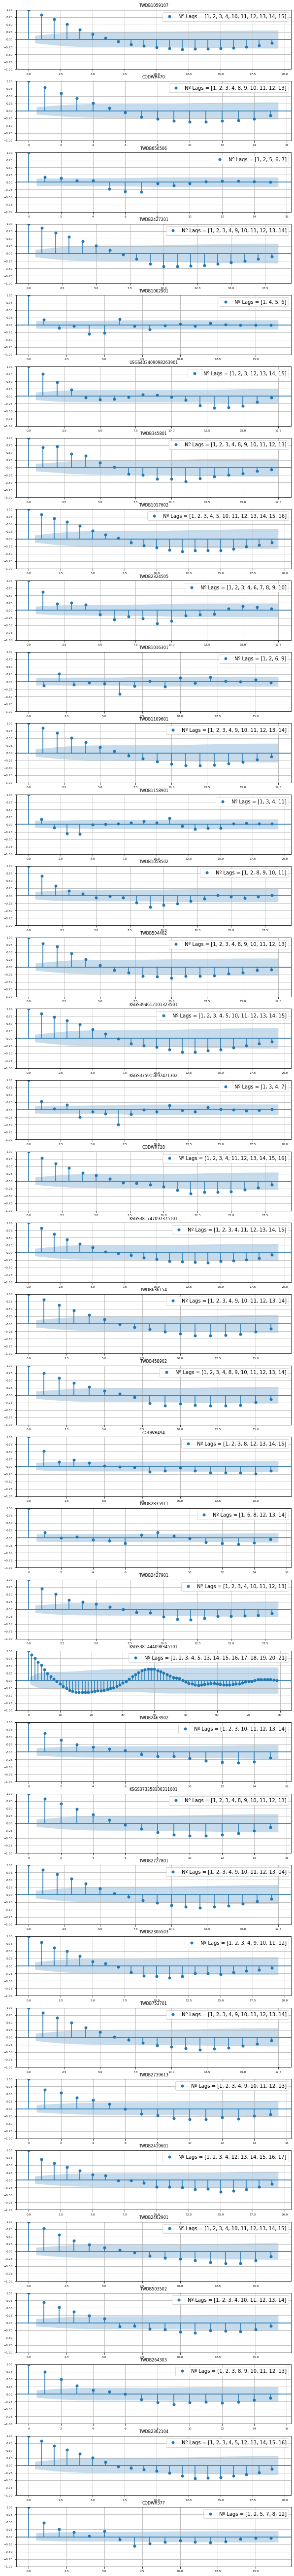

In [26]:
Autocorrelation(Accepted_80)

Application of the Mann-Kendall test on both thresholds. This function will return a DataFrame containing the results of the hypothesis tests, slope, intercept, autocorrelation, and other relevant values. 



In [27]:
MK_Accepted_90 = MK_tests(Accepted_90, num1 = 1, num2 = 2)

Mann Kendall Test to execute: mk.original_test y mk.hamed_rao_modification_test


In [28]:
MK_Accepted_90.head()

,Well,Trends_MK1,Trends_MK2,h_MK1,h_MK2,p_MK1,p_MK2,slope_MK1,slope_MK2,intercept_MK1,intercept_MK2,Autocorrelation,Nº Lags
0,TWDB1059107,decreasing,decreasing,True,True,2.060226e-07,0.003230,0.010957,0.010957,31.821354,31.821354,"[1, 2, 3, 4, 10, 11, 12, 13, 14, 15]",10
1,TWDB2427201,decreasing,decreasing,True,True,1.538964e-07,0.006500,0.023147,0.023147,57.162378,57.162378,"[1, 2, 3, 4, 9, 10, 11, 12, 13, 14]",10
2,USGS403409098263901,decreasing,decreasing,True,True,9.453565e-05,0.008427,0.011389,0.011389,37.054167,37.054167,"[1, 2, 3, 12, 13, 14, 15]",7
3,TWDB345801,decreasing,decreasing,True,True,4.299031e-05,0.027634,0.034311,0.034311,81.409192,81.409192,"[1, 2, 3, 4, 8, 9, 10, 11, 12, 13]",10
4,TWDB1017602,decreasing,decreasing,True,True,4.179743e-08,0.008201,0.010543,0.010543,57.793378,57.793378,"[1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16]",12


In [29]:
MK_Accepted_80 = MK_tests(Accepted_80, num1 = 1, num2 = 2)

Mann Kendall Test to execute: mk.original_test y mk.hamed_rao_modification_test


In [30]:
MK_Accepted_80.head()

,Well,Trends_MK1,Trends_MK2,h_MK1,h_MK2,p_MK1,p_MK2,slope_MK1,slope_MK2,intercept_MK1,intercept_MK2,Autocorrelation,Nº Lags
0,TWDB1059107,decreasing,decreasing,True,True,2.060226e-07,0.003230,0.010957,0.010957,31.821354,31.821354,"[1, 2, 3, 4, 10, 11, 12, 13, 14, 15]",10
1,CODWR470,decreasing,decreasing,True,True,1.454342e-06,0.008225,0.025579,0.025579,49.176167,49.176167,"[1, 2, 3, 4, 8, 9, 10, 11, 12, 13]",10
2,TWDB650506,increasing,increasing,True,True,9.574666e-02,0.095747,-0.010754,-0.010754,55.869586,55.869586,"[1, 2, 5, 6, 7]",5
3,TWDB2427201,decreasing,decreasing,True,True,1.538964e-07,0.006500,0.023147,0.023147,57.162378,57.162378,"[1, 2, 3, 4, 9, 10, 11, 12, 13, 14]",10
4,TWDB1002901,increasing,increasing,True,True,6.378664e-02,0.063787,-0.001510,-0.001510,84.427784,84.427784,"[1, 4, 5, 6]",4


Mann Kendall Test to execute: mk.original_test y mk.hamed_rao_modification_test


23it [00:03,  6.55it/s]


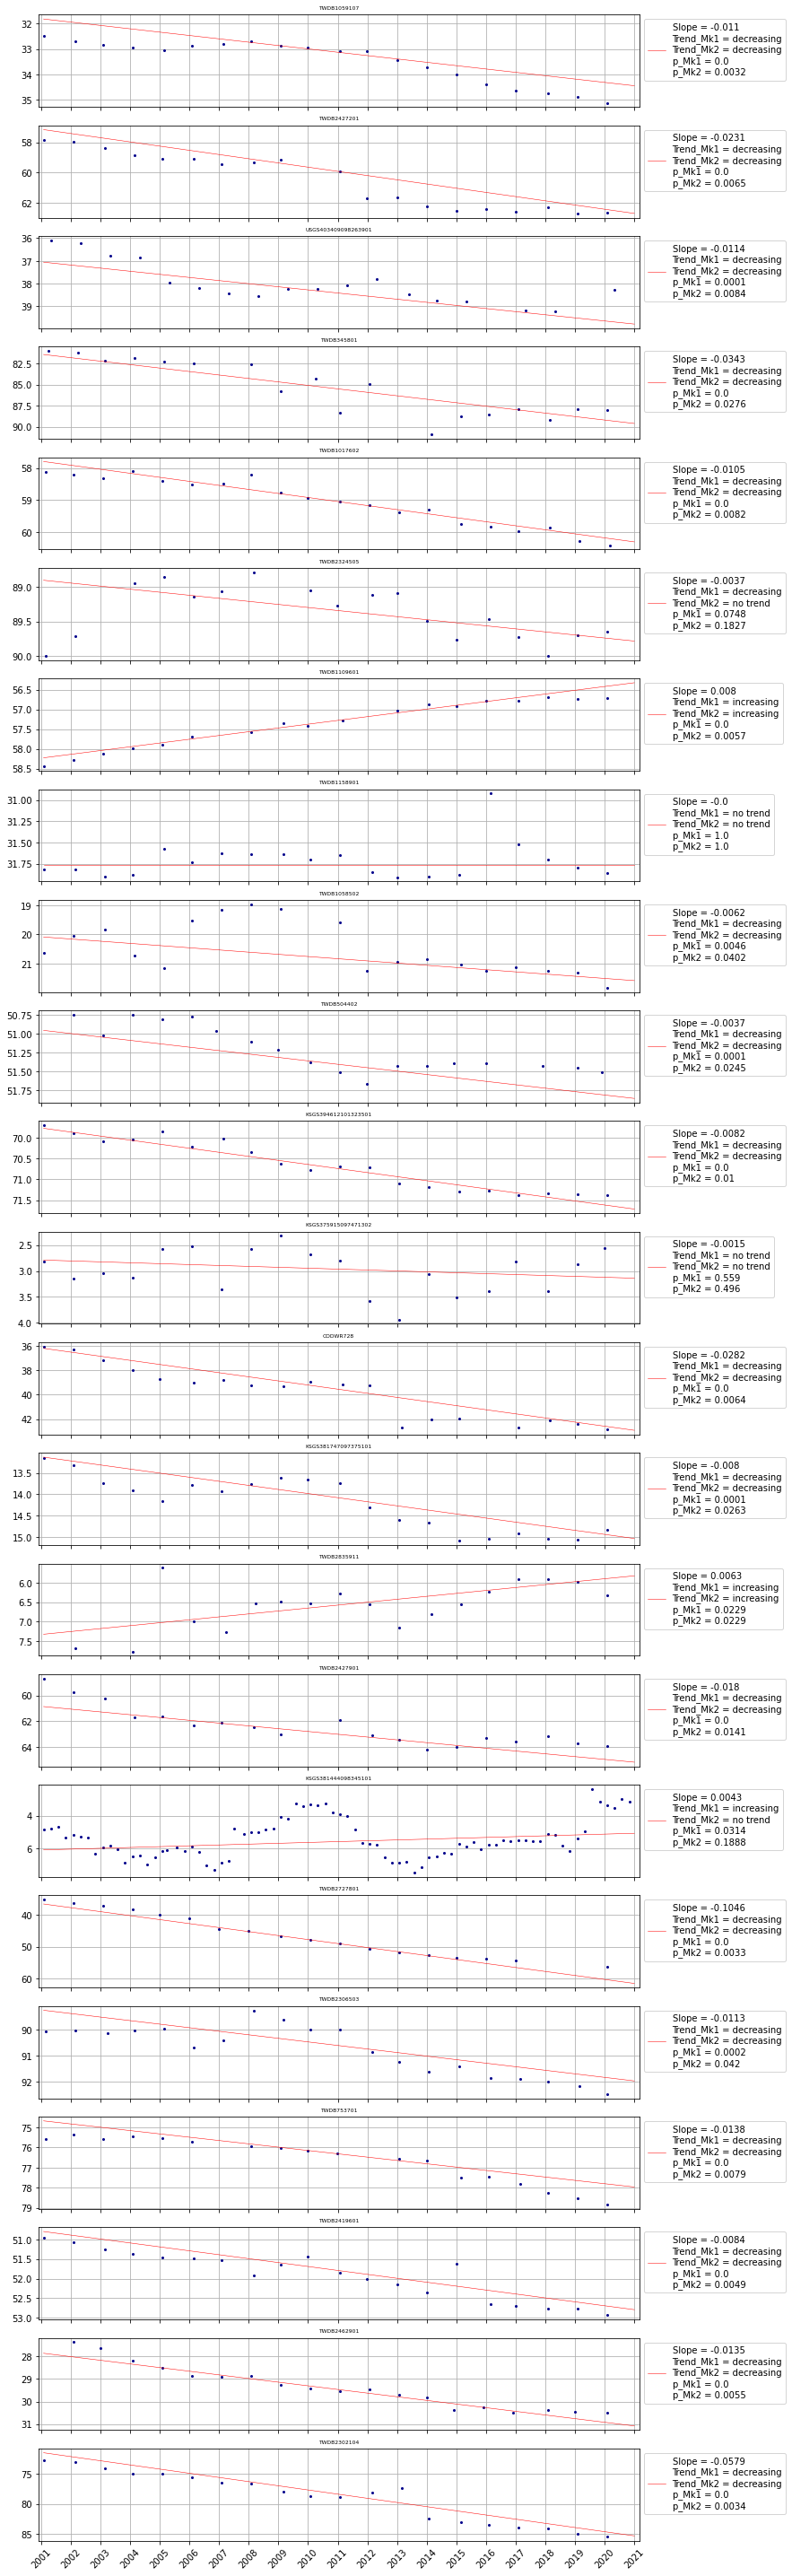

In [31]:
MK_plot(Accepted_90, num1 = 1, num2 = 2, alpha = 0.1, savefig = False)

Mann Kendall Test to execute: mk.original_test y mk.hamed_rao_modification_test


36it [00:06,  5.72it/s]


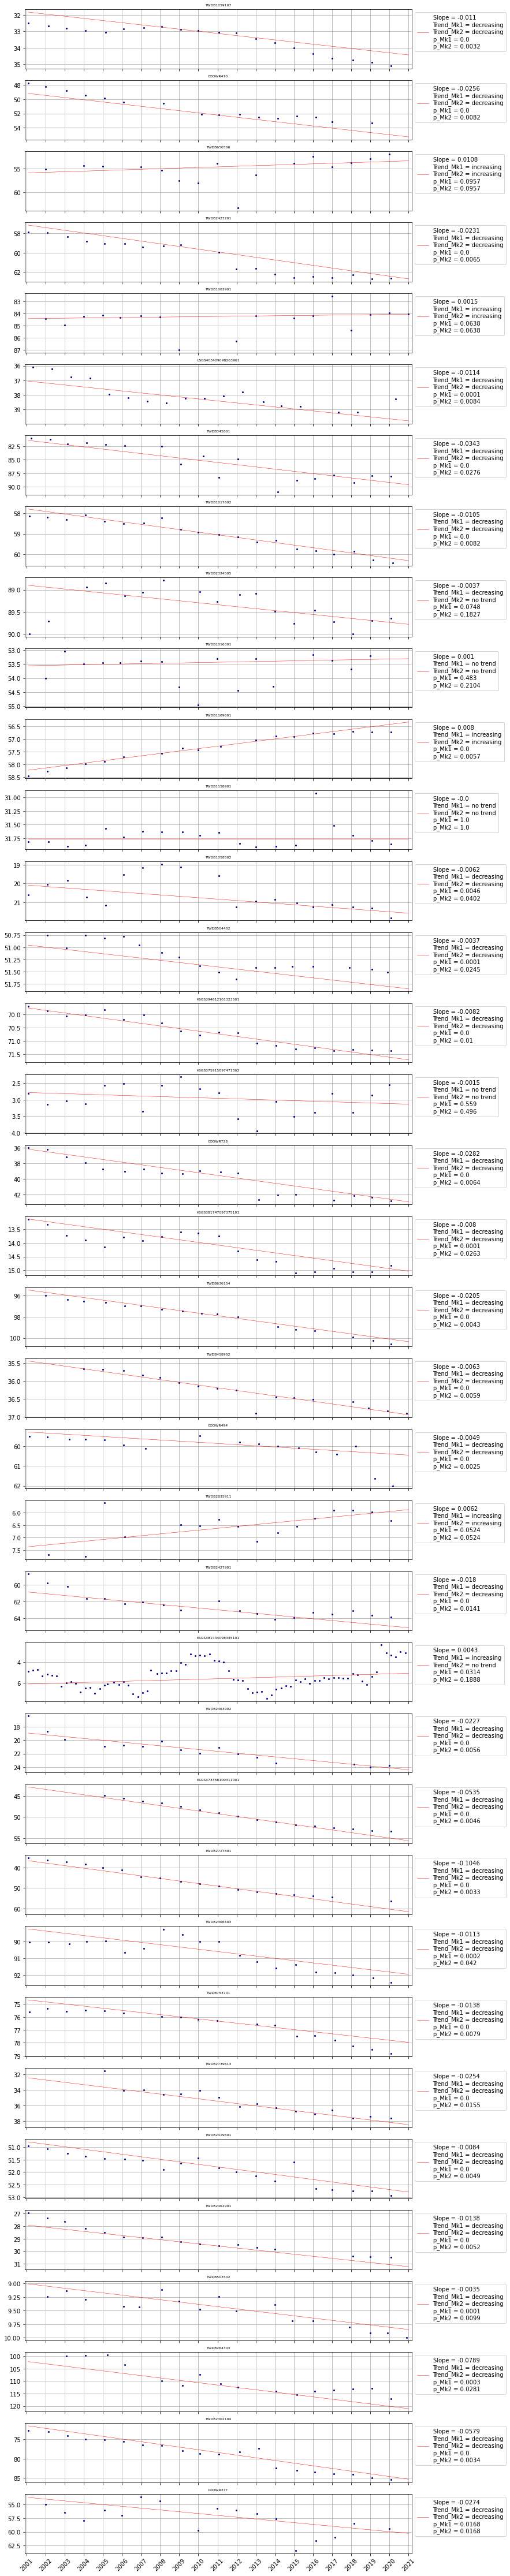

In [32]:
MK_plot(Accepted_80, num1 = 1, num2 = 2, alpha = 0.1, savefig = False)